# Prueba Técnica Data Engineer Junior

### VERIFICACION DE TU BASE DE DATOS NEPTUNE
#### Verifica que tu base de datos tenga la siguiente  configuración antes de ejecutar esta script
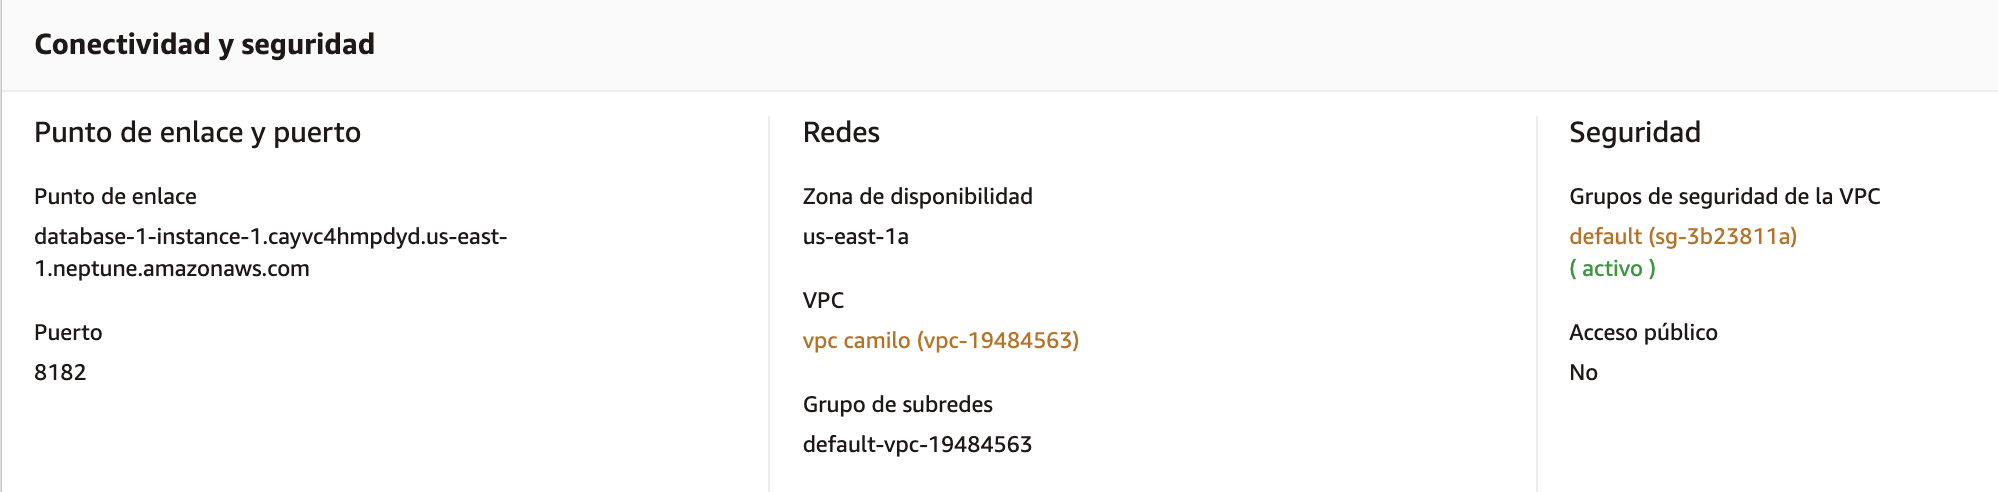
### REQUIRIMIENTOS PARA CORRER ESTA SCRIPT

<ol>
<li >Ejecutar la primera celda donde se encuentra el codigo <b><code>pip install xlrd==1.2.0</code></b> para instalar el modulo llamado xlrd con la version 1.2.0, y reiniciar el Kernel de notebook Jupyter <br></li><br>
    
<li> Ejecutar la segunda celda para correr las funciones <b>creatingVertex y creatingEdge</b> </li><br>
    
<li> En la tercera celda ubicar la variable "neptuneEndpoint" e inizializarla con la url de tu base de datos Neptune, como en este ejemplo <code>"database-andres-instance-1.cayvc4hmpdyd.us-east-1.neptune.amazonaws.com"</code>(debe ir entre comillas la url de tu base de datos), debes asegurarte que la instancia de tu base de datos tengo el permiso de escritura </li><br>

<li> Debe estar el archivo llamado <b>"Matriz_de_adyacencia_data_team.xlsx"</b>, este debe estar ubicado en el <b>root de tu notebook Jupyter</b>, al igual que debe estar esta script</li><br>

<li> Si cumpliste los dos pasos anterios puedes ejecutar la tercera celda de esta script para crear los <b>vertex y los edges</b>, estos se crean con <b>query de Gremlin con python</b></li><br>

<li> En la cuarta celda donde esta ubicada <code>"your-neptune-enpoint"</code> debe ser remplazado pero el url de tu base de datos Neptune,(debe ir entre comillas la url de tu base de datos), asegurate que sea la misma url que insertaste en el primer paso</li><br>

<li> Si cumpliste el paso anterior puedes ejecutar la cuarta celda para la configuración, si aparecio <b>un error ejecutando esta celda</b>, guarda los cambios que has hecho, cierra el archivo y vuelve a ingresar, esto pasa porque se debe encender el archivo en notebook para poder ejecutar los comandos de gremlin</li><br>

<li> Si cumpliste todos los pasos anteriores correctamente, ejecuta la ultima celda para visualizar el grafico con los datos que han sido ingresados en la base de datos</li><br>
</ol>

In [ ]:
pip install xlrd==1.2.0

In [ ]:
def creatingVertex(data):
    for index,row in data.iterrows():
        g.addV('PERSONA').\
        property(T.id,str(row["id"])).\
        property("name",row["name"]).\
        property("nickname", row["nickname"]).next()

def creatingEdge(checkUnion):
    for indexRow, row in enumerate(checkUnion):
        if not True in row:
            continue
        for indexColumn, column in enumerate(row):
            if column == True:
                client= g.V(str(int(indexRow + 1))).toList()[0]
                finalClient = g.V(str(int(indexColumn + 1))).toList()[0]
                
                g.V(client).addE('PERSONA').to(finalClient).property('weight',0.75).iterate()

In [ ]:
from __future__  import print_function  # Python 2/3 compatibility
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import T
import pandas as pd

graph = Graph()

neptuneEndpoint="your-neptune-endpoint"
remoteConn = DriverRemoteConnection(f'wss://{neptuneEndpoint}:8182/gremlin','g')
g = graph.traversal().withRemote(remoteConn)

namesHeader = ["nickname", "id", "name"]
fileXLSX = "./Matriz_de_adyacencia_data_team.xlsx"

checkFile= False

try:
    listaDeActores = pd.read_excel(fileXLSX, "Lista de actores", header=2, names=namesHeader)
    matrizDeAdyacencia = pd.read_excel(fileXLSX, "Matriz de adyacencia", header=1)
    
    checkFile = True
    
except FileNotFoundError:
    checkFile = False

if checkFile:
    checkUnion = (matrizDeAdyacencia.values > 0 ).tolist()

    g.V().drop().iterate()

    creatingVertex(listaDeActores)
    creatingEdge(checkUnion)

    print(g.V().limit(100).toList()) # Showing all Vertex with the Id
    print(g.V().count().next()) # Showing the number of vertices 
    print(g.V().outE().elementMap().toList()) # Showing all the edges

else:
    print(f"The File called {fileXLSX} Doen't Exist ")

remoteConn.close()


In [ ]:
%%graph_notebook_config
{
  "host": "your-neptune-enpoint",
  "port": 8182,
  "auth_mode": "DEFAULT",
  "load_from_s3_arn": "",
  "ssl": true,
  "aws_region": "us-east-1a"
}


In [ ]:
%%gremlin -p v,ine,outv,oute,inv,oute,inv
g.V().hasLabel("PERSONA").inE().outV().outE().inV().outE().inV().path().by("name").by(label)